# Topology run8 after fidutial selection

## DEMO Run8


### April 2021, JAH

In [39]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [40]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt


In [41]:
import hipy.utils        as ut
import hipy.pltext       as pltext

import next.core.io        as nio
import next.core.selection as nsel

import next.eres.eres      as eres

In [42]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Mon Apr 19 12:36:02 2021


### load data

In [43]:
run       = 'run8'
filename  = f'/home/hernando/data/demo/{run}/dfesme_fidutial_combined.h5'
dft       = pd.read_hdf(filename, 'esme')
print('total number of events ', len(dft))

total number of events  1828937


### Inspect DF

In [44]:
columns = list(dft.columns)
print(columns)
i = columns.index('evt_out_of_map') # problems with plotting, remove from the list to plot
columns.pop(i)
#pltext.df_inspect(dft, columns, ncolumns = 3)

['event', 'trackID', 'energy', 'length', 'numb_of_voxels', 'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'dz_track', 'enecor', 'time', 'nS2', 'S1e', 'S2e', 'S2q', 'Nsipm', 'evt_energy', 'evt_ntrks', 'evt_nhits', 'evt_out_of_map', 'run']


'evt_out_of_map'

### selections and ranges

In [45]:
ranges = {'nS2'            : (1., 1.),
          'evt_out_of_map' : (False, False),
          'numb_of_tracks' : (1., 1.),
          'z_min'          : (15., 300.),
          'z_max'          : (15., 300.),
          'r_max'          : (0.,  55.),
          'energy'         : (0., 3.),
          'energy.cs'      : (0.65, 0.75),
          'energy.ds'      : (1.62, 1.85),
          'energy.ph'      : (2.00, 3.00),
          'dz_track.cs'    : (0., 60.),
          'dz_track.ds'    : (0., 120.),
         }
for key in ranges.keys():
    print(key, ranges[key])

nS2 (1.0, 1.0)
evt_out_of_map (False, False)
numb_of_tracks (1.0, 1.0)
z_min (15.0, 300.0)
z_max (15.0, 300.0)
r_max (0.0, 55.0)
energy (0.0, 3.0)
energy.cs (0.65, 0.75)
energy.ds (1.62, 1.85)
energy.ph (2.0, 3.0)
dz_track.cs (0.0, 60.0)
dz_track.ds (0.0, 120.0)


In [46]:
selections = nsel.Selections(dft, ranges)

### Indentify where is the Ds in z, x, y

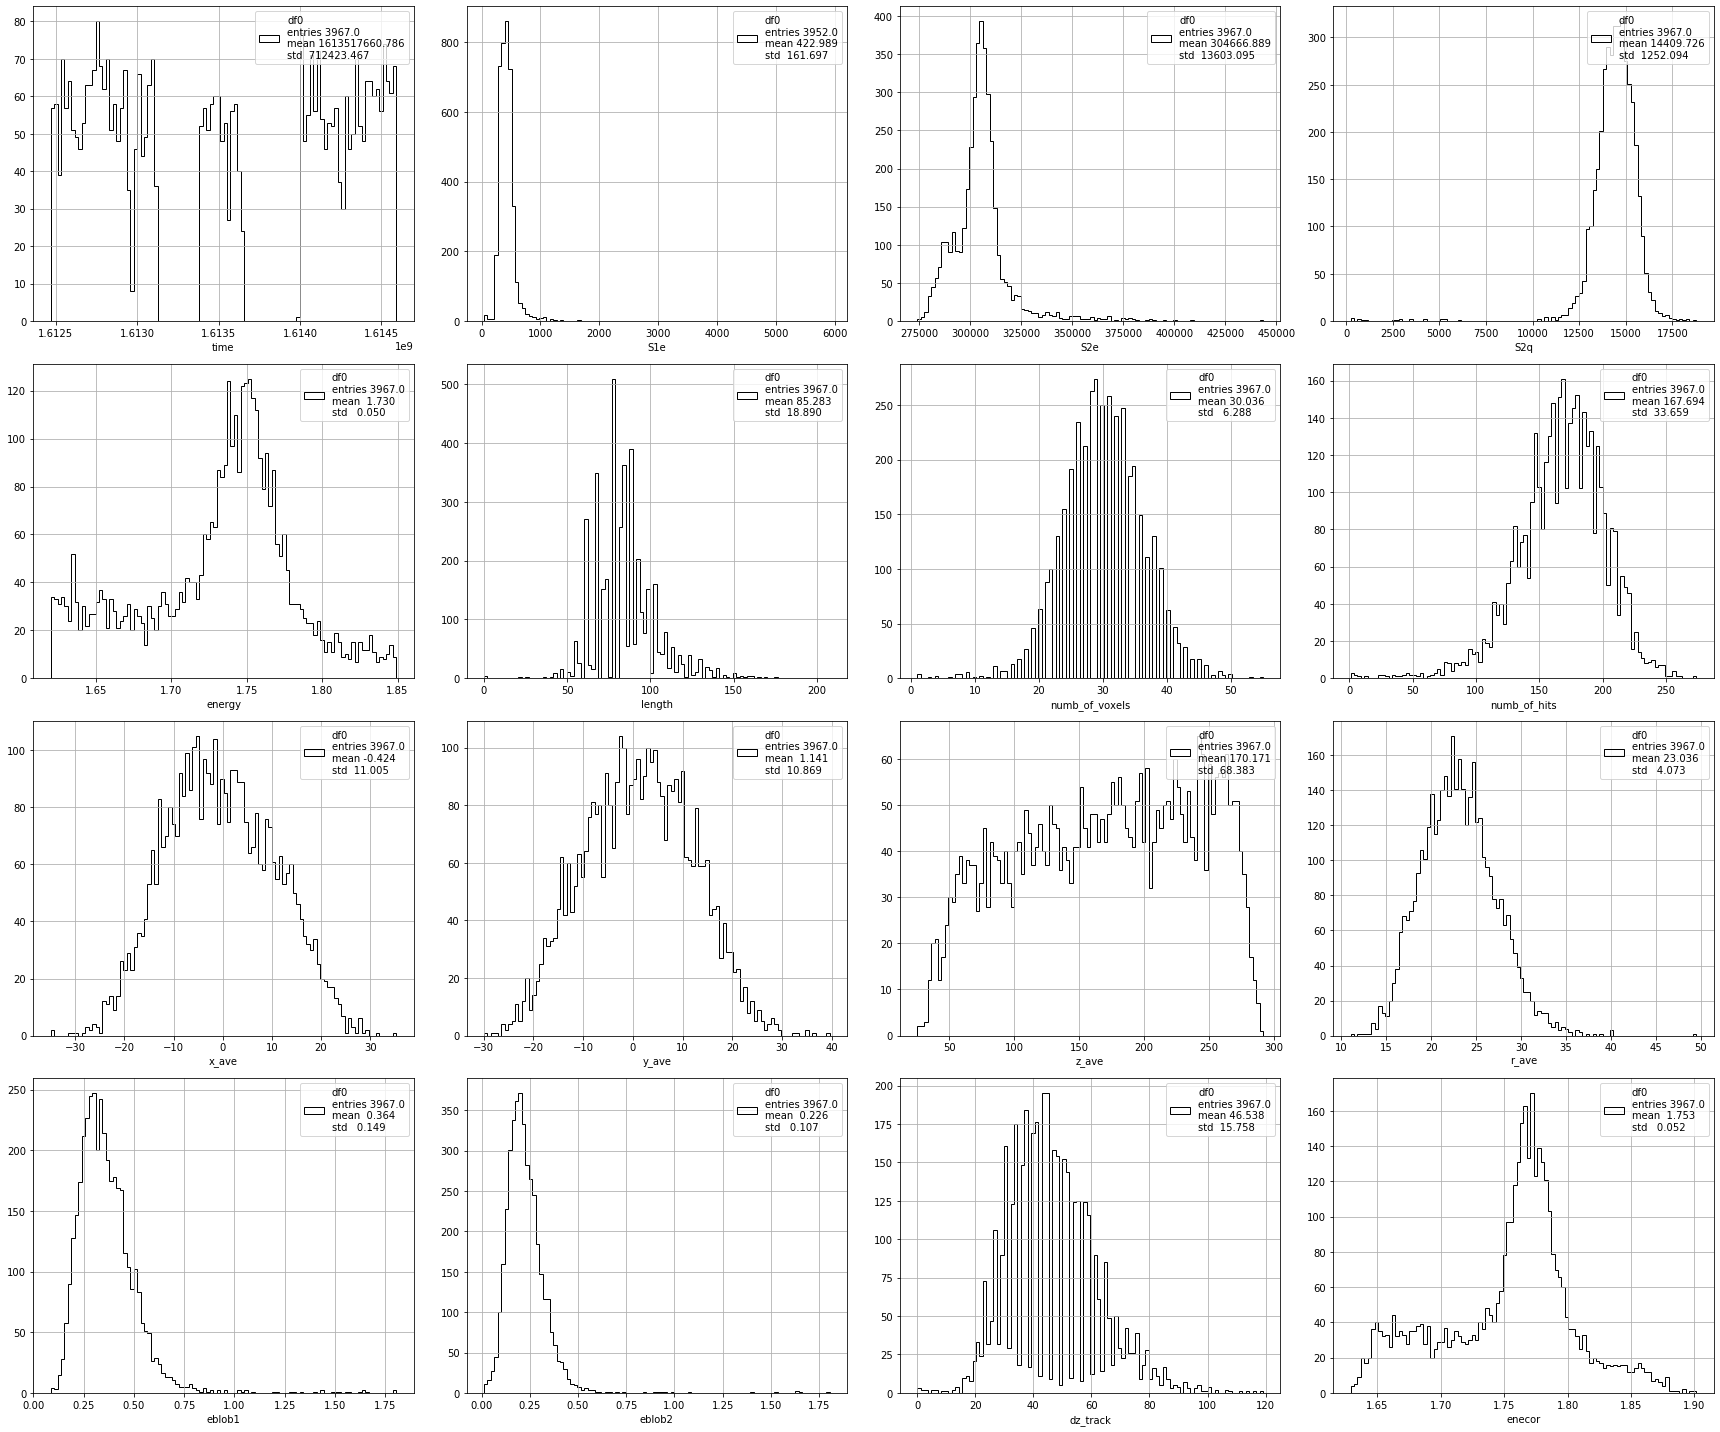

In [47]:
sel = selections['energy.ds']

labels = ['time', 'S1e', 'S2e', 'S2q',
          'energy', 'length', 'numb_of_voxels', 'numb_of_hits',
          'x_ave', 'y_ave', 'z_ave', 'r_ave',
          'eblob1', 'eblob2',
          'dz_track', 'enecor']
pltext.df_inspect(dft[sel], labels, ncolumns = 4)

**Conclusions**

   * DS is equaly distributed in x, y, z


## Energy resolution - Delta z correction

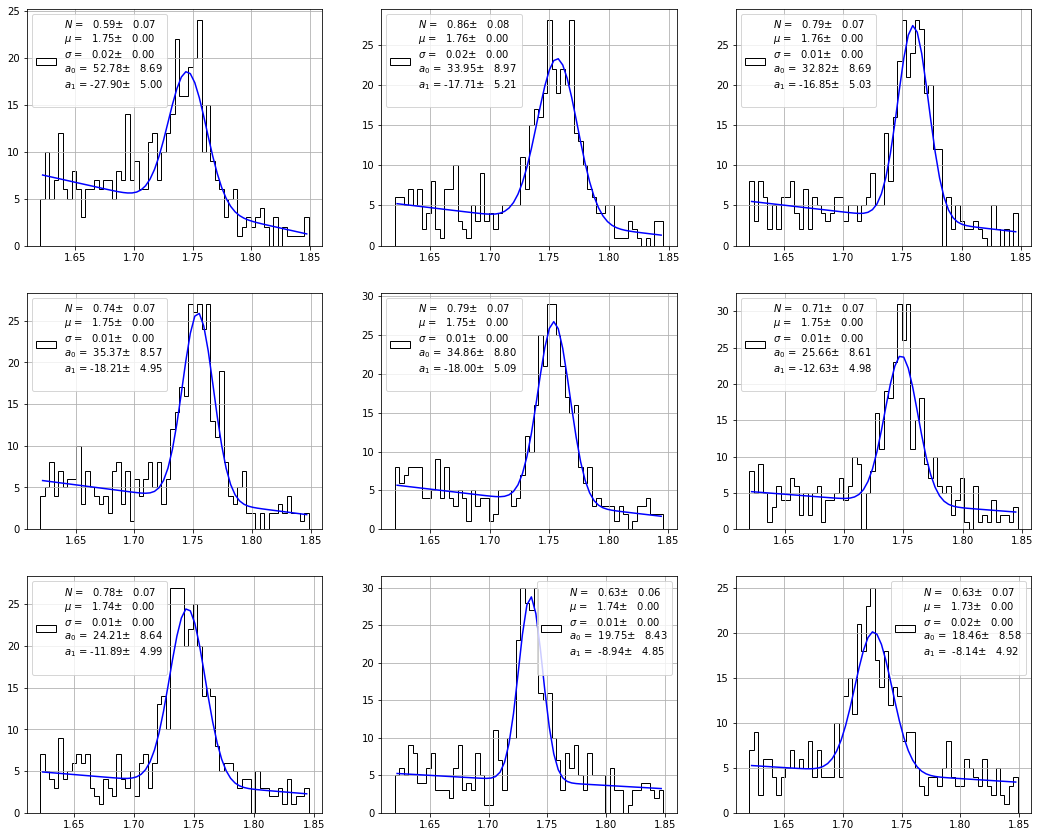

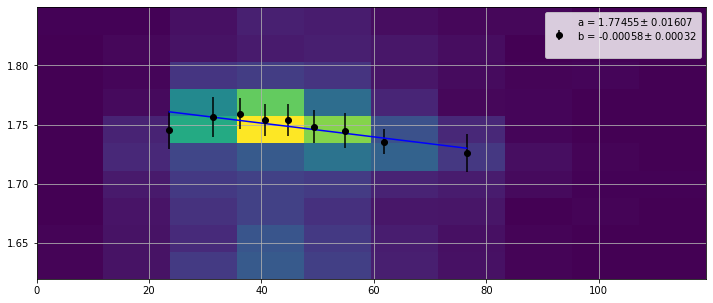

In [48]:
sel   = selections.logical_and(('energy.ds', 'dz_track.ds'), 'ds')
names = ('energy', 'dz_track')

ene, dz = [dft[sel][name].values for name in names]

nbins = 10
p0s   = 10*((10, 1.75, 0.02,10, -10),)

xmed, mus, sigs, pars, upars = eres.dz_effect(dz, ene,  nbins, p0s = p0s, plot = True)

In [49]:
alpha = abs(pars[1]/pars[0])
scale = 1.
print('alpha, scale', alpha, scale)

ene, dz = dft.energy.values, dft.dz_track.values
enecor  = eres.dz_energy_correction(ene, dz, alpha, scale)
dft.enecor = np.copy(enecor)
ranges['enecor.cs'] = (0.67, 0.78)
ranges['enecor.ds'] = (1.65, 1.87)
selections.set_range('enecor.cs', ranges['enecor.cs']);
selections.set_range('enecor.ds', ranges['enecor.ds']);

alpha, scale 0.0003270543838096249 1.0


(0.7227161132179303, 0.007663862827523138, 3.531970578553039e-05, 2.4919989073563875, 0.011484635125461483)
resolution R = 2.4920 +- 0.01148
(1.775316419323661, 0.015470452952755029, 0.000454633327623241, 2.0478357572350188, 0.060180163281632816)
resolution R = 2.0478 +- 0.06018


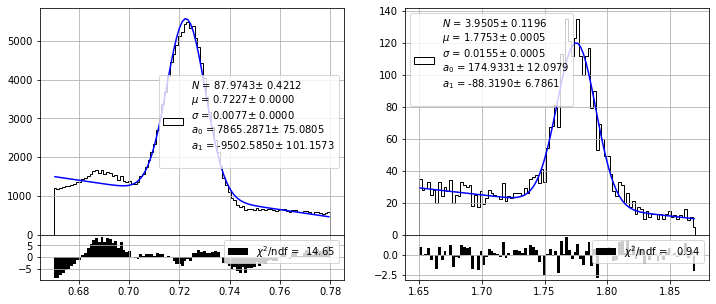

In [50]:
ename   = 'enecor'
eranges = [ranges[name] for name in (ename + '.cs', ename + '.ds')]
subplot = pltext.canvas(len(eranges))
for i, erange in enumerate(eranges):
    subplot(i + 1)
    pars = eres.energy_fit(dft[ename].values, 100, range = erange, plot = True)
    print(pars)
    print('resolution R = {0:6.4f} +- {1:6.5f}'.format(*pars[-2:]))

### Blob distributions

2603


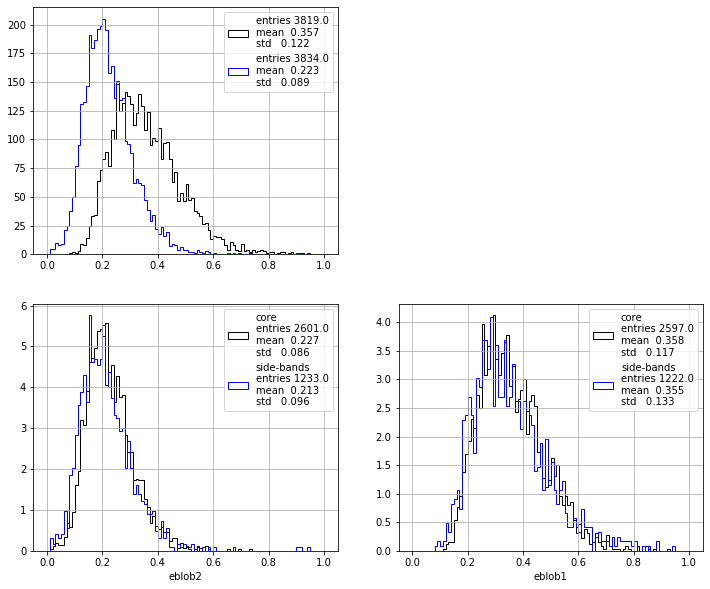

In [51]:
sel    = selections['enecor.ds']
erange = ranges['enecor.ds']
enecor = dft.enecor[sel].values 
usel   = ut.in_range(enecor, (1.73, 1.82))
print(np.sum(usel))

eblob1, eblob2 = [dft[sel][name].values for name in ('eblob1', 'eblob2')]

subplot = pltext.canvas(4)
subplot(1)
pltext.hist(eblob1, 100, range = (0., 1.));
pltext.hist(eblob2, 100, range = (0., 1.));

subplot(3)
pltext.hist(eblob2[ usel], 100, range = (0., 1.), density = True, label = 'core');
pltext.hist(eblob2[~usel], 100, range = (0., 1.), density = True, label = 'side-bands');
plt.xlabel('eblob2');

subplot(4)
pltext.hist(eblob1[ usel], 100, range = (0., 1.), density = True, label = 'core');
pltext.hist(eblob1[~usel], 100, range = (0., 1.), density = True, label = 'side-bands');
plt.xlabel('eblob1'); 

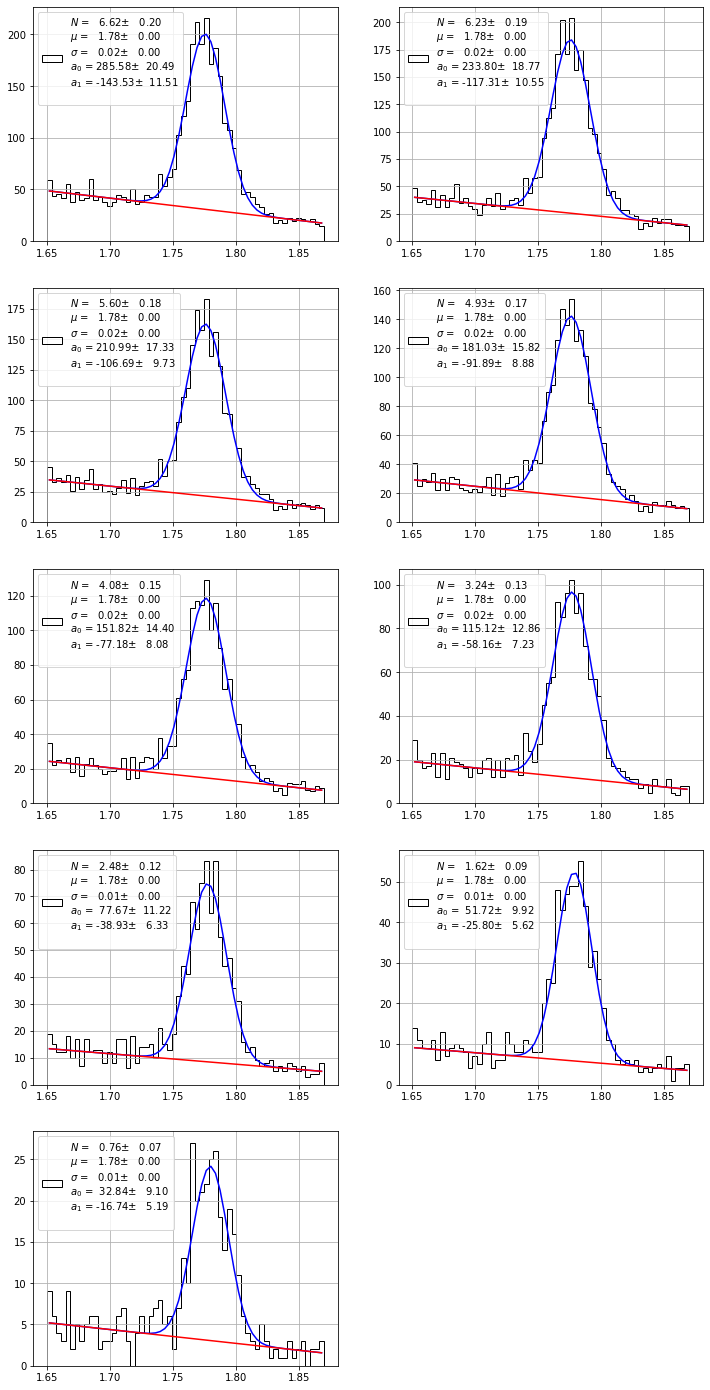

In [60]:
ename  = 'enecor'
nscan  = 10
mbins  = 60
sel    = selections[ename + '.ds']
ene, eblob1, eblob2 = [dft[sel][name].values for name in ('enecor', 'eblob1', 'eblob2')]

eblob2_scan, nsigs, nbkgs = eres.ds_eblob2scan(ene, eblob2, nscan, mbins, plot = True)

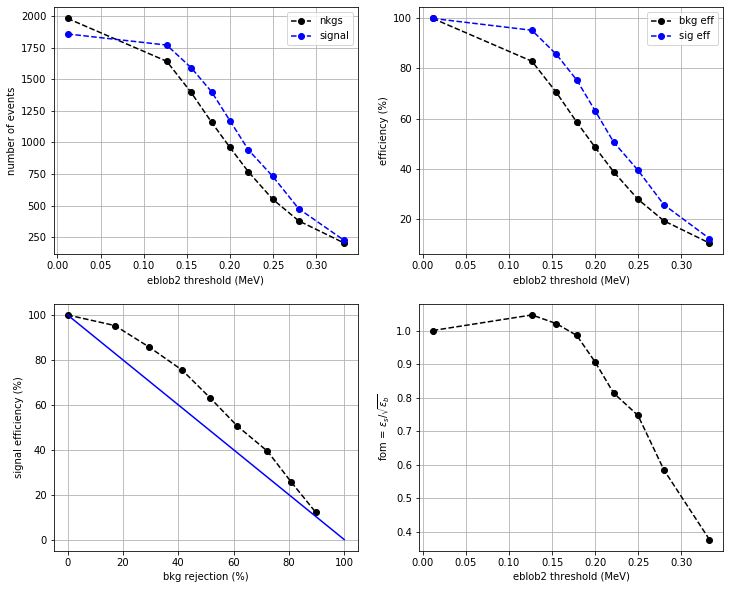

In [62]:
eres.plt_eblob2scan(eblob2_scan, nsigs, nbkgs)